**Installing Required Packages**

In [ ]:
install.packages("dplyr")
install.packages("keras")
install.packages("tidyquant")
install.packages("quantmod")
install.packages("tseries")
install.packages("forecast")
install.packages("TTR")
install.packages("corrplot")
install.packages("lubridate")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘plotly’, ‘alphavantager’, ‘timetk’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: lubridate


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Loading required p

In [ ]:
library(dplyr)
library(ggplot2)
library(keras)
library(tidyquant)
library(quantmod)
library(forecast)
library(tseries)
library(scales)
# library(TTR)
# library(corrplot)
# library(lubridate


######################### Warning from 'xts' package ##########################
#                                                                             #
# The dplyr lag() function breaks how base R's lag() function is supposed to  #
# work, which breaks lag(my_xts). Calls to lag(my_xts) that you type or       #
# source() into this session won't work correctly.                            #
#                                                                             #
# Use stats::lag() to make sure you're not using dplyr::lag(), or you can add #
# conflictRules('dplyr', exclude = 'lag') to your .Rprofile to stop           #
# dplyr from breaking base R's lag() function.                                #
#                                                                             #
# Code in packages is not affected. It's protected by R's namespace mechanism #
# Set `options(xts.warn_dplyr_breaks_lag = FALSE)` to suppress this warning.  #
#                                      

**Loading data**

In [ ]:
file_path <- "/content/bankNifty_12thApr.csv"

data <- read.csv(file_path)

**Size of dataset**

In [ ]:
print(dim(data))

print(nrow(data))

print(ncol(data))

[1] 4090    7
[1] 4090
[1] 7


# **Pre-processing**

**P1. Converting all columns to numeric datatype**

In [ ]:
numeric_cols <- c('Open', 'High', 'Low', 'Close', 'Adj.Close', 'Volume')

data[numeric_cols] <- lapply(data[numeric_cols], as.numeric)

Warning message in lapply(data[numeric_cols], as.numeric):
“NAs introduced by coercion”
Warning message in lapply(data[numeric_cols], as.numeric):
“NAs introduced by coercion”
Warning message in lapply(data[numeric_cols], as.numeric):
“NAs introduced by coercion”
Warning message in lapply(data[numeric_cols], as.numeric):
“NAs introduced by coercion”
Warning message in lapply(data[numeric_cols], as.numeric):
“NAs introduced by coercion”
Warning message in lapply(data[numeric_cols], as.numeric):
“NAs introduced by coercion”


In [ ]:
str(data)

'data.frame':	4090 obs. of  7 variables:
 $ Date     : chr  "2007-09-17" "2007-09-18" "2007-09-19" "2007-09-20" ...
 $ Open     : num  6898 6921 7111 7405 7378 ...
 $ High     : num  6977 7079 7419 7463 7506 ...
 $ Low      : num  6843 6884 7111 7344 7367 ...
 $ Close    : num  6897 7060 7402 7390 7464 ...
 $ Adj.Close: num  6897 7060 7402 7390 7464 ...
 $ Volume   : num  0 0 0 0 0 0 0 0 0 0 ...


In [ ]:
print(head(data))

        Date    Open    High     Low   Close Adj.Close Volume
1 2007-09-17 6898.00 6977.20 6843.00 6897.10  6897.020      0
2 2007-09-18 6921.15 7078.95 6883.60 7059.65  7059.568      0
3 2007-09-19 7111.00 7419.35 7111.00 7401.85  7401.764      0
4 2007-09-20 7404.95 7462.90 7343.60 7390.15  7390.064      0
5 2007-09-21 7378.30 7506.35 7367.15 7464.50  7464.413      0
6 2007-09-24 7514.40 7661.05 7514.40 7650.90  7650.811      0


**P2. Summary of Data**

In [ ]:
summary(data)

     Date                Open            High            Low       
 Length:4090        Min.   : 3385   Min.   : 3447   Min.   : 3315  
 Class :character   1st Qu.:10308   1st Qu.:10414   1st Qu.:10180  
 Mode  :character   Median :18386   Median :18539   Median :18227  
                    Mean   :20869   Mean   :21033   Mean   :20676  
                    3rd Qu.:30228   3rd Qu.:30480   3rd Qu.:29960  
                    Max.   :48880   Max.   :49057   Max.   :48669  
                    NA's   :303     NA's   :303     NA's   :303    
     Close         Adj.Close         Volume         
 Min.   : 3340   Min.   : 3340   Min.   :0.000e+00  
 1st Qu.:10289   1st Qu.:10289   1st Qu.:0.000e+00  
 Median :18373   Median :18372   Median :0.000e+00  
 Mean   :20856   Mean   :20856   Mean   :6.583e+05  
 3rd Qu.:30216   3rd Qu.:30215   3rd Qu.:4.165e+04  
 Max.   :48987   Max.   :48987   Max.   :1.798e+09  
 NA's   :303     NA's   :303     NA's   :303        

**P3. Counting missing values**

In [ ]:
na_counts <- colSums(is.na(data))
print(na_counts)

     Date      Open      High       Low     Close Adj.Close    Volume 
        0       303       303       303       303       303       303 


**P4. Imputing missing values with moving averages**

In [ ]:
#Imputing Missing values with moving averages
# Define a function to replace NA values with local mean within a specified range
impute_local_mean <- function(x, range = 35) {
  # Create a vector to store imputed values
  imputed_values <- numeric(length(x))

  # Iterate over each element in the vector
  for (i in seq_along(x)) {
    if (is.na(x[i])) {
      # Calculate the local mean within the specified range
      lower_bound <- max(1, i - range)
      upper_bound <- min(length(x), i + range)
      local_values <- x[lower_bound:upper_bound]
      imputed_values[i] <- mean(local_values, na.rm = TRUE)
    } else {
      # Keep the original value if it's not NA
      imputed_values[i] <- x[i]
    }
  }

  return(imputed_values)
}
# Apply the custom imputation function to each column of the dataframe
clean_data <- as.data.frame(lapply(data, impute_local_mean))
# Note: Replace 'data' with the name of your dataframe containing NA values
clean_data


Date,Open,High,Low,Close,Adj.Close,Volume
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2007-09-17,6898.00,6977.20,6843.00,6897.10,6897.020,0
2007-09-18,6921.15,7078.95,6883.60,7059.65,7059.568,0
2007-09-19,7111.00,7419.35,7111.00,7401.85,7401.764,0
2007-09-20,7404.95,7462.90,7343.60,7390.15,7390.064,0
2007-09-21,7378.30,7506.35,7367.15,7464.50,7464.413,0
2007-09-24,7514.40,7661.05,7514.40,7650.90,7650.811,0
2007-09-25,7658.50,7694.25,7490.20,7629.15,7629.061,0
2007-09-26,7647.10,7829.85,7591.80,7755.90,7755.810,0
2007-09-27,7804.55,7866.50,7747.10,7833.65,7833.559,0


**Re-counting missing values**

In [ ]:
na_counts <- colSums(is.na(clean_data))
print(na_counts)

     Date      Open      High       Low     Close Adj.Close    Volume 
        0         0         0         0         0         0         0 


**P5. Replacing "0" values in Volume column**

In [ ]:
# Set seed for reproducibility (optional)
set.seed(123)

# Identify zero values in the volume column
zero_indices <- which(clean_data$Volume == 0)

# Calculate the number of zero values
num_zeros <- length(zero_indices)

# Generate random integers between 200,000 and 300,000
random_numbers <- sample(200000:500000, size = num_zeros, replace = TRUE)

# Replace zero values in the volume column with random numbers
clean_data$Volume[zero_indices] <- random_numbers

# Convert the volume column to integer type
clean_data$Volume <- as.integer(clean_data$Volume)


# Display the updated dataset
print(clean_data)

           Date      Open      High       Low     Close Adj.Close     Volume
1    2007-09-17  6898.000  6977.200  6843.000  6897.100  6897.020     388941
2    2007-09-18  6921.150  7078.950  6883.600  7059.650  7059.568     334057
3    2007-09-19  7111.000  7419.350  7111.000  7401.850  7401.764     324021
4    2007-09-20  7404.950  7462.900  7343.600  7390.150  7390.064     360996
5    2007-09-21  7378.300  7506.350  7367.150  7464.500  7464.413     426317
6    2007-09-24  7514.400  7661.050  7514.400  7650.900  7650.811     324506
7    2007-09-25  7658.500  7694.250  7490.200  7629.150  7629.061     393626
8    2007-09-26  7647.100  7829.850  7591.800  7755.900  7755.810     245403
9    2007-09-27  7804.550  7866.500  7747.100  7833.650  7833.559     265160
10   2007-09-28  7838.250  8082.850  7836.050  8042.200  8042.107     259133
11   2007-10-01  8008.550  8085.150  7913.300  7987.500  7987.407     383203
12   2007-10-03  8029.800  8235.800  7820.250  8097.900  8097.806     345254

**P6. Feature Engineering**

**Adding column "Today's Opening Price and Closing Price Difference"**

In [ ]:
# Add a new column 'difference' to calculate the price difference
clean_data$Today_point_difference <- clean_data$Close - clean_data$Open

# Display the updated dataset with the new 'difference' column
print(clean_data)

           Date      Open      High       Low     Close Adj.Close     Volume
1    2007-09-17  6898.000  6977.200  6843.000  6897.100  6897.020     388941
2    2007-09-18  6921.150  7078.950  6883.600  7059.650  7059.568     334057
3    2007-09-19  7111.000  7419.350  7111.000  7401.850  7401.764     324021
4    2007-09-20  7404.950  7462.900  7343.600  7390.150  7390.064     360996
5    2007-09-21  7378.300  7506.350  7367.150  7464.500  7464.413     426317
6    2007-09-24  7514.400  7661.050  7514.400  7650.900  7650.811     324506
7    2007-09-25  7658.500  7694.250  7490.200  7629.150  7629.061     393626
8    2007-09-26  7647.100  7829.850  7591.800  7755.900  7755.810     245403
9    2007-09-27  7804.550  7866.500  7747.100  7833.650  7833.559     265160
10   2007-09-28  7838.250  8082.850  7836.050  8042.200  8042.107     259133
11   2007-10-01  8008.550  8085.150  7913.300  7987.500  7987.407     383203
12   2007-10-03  8029.800  8235.800  7820.250  8097.900  8097.806     345254

**Adding column "Closing (Prev.) and Opening (Curr.) Difference**

In [ ]:
# Assuming 'data' is your dataframe containing stock market data with columns: date, open_price, high_price, low_price, close_price, adj_close_price, volume
# Sort the dataframe by date (if not already sorted)
clean_data <- clean_data[order(clean_data$Date), ]

# Calculate the difference between yesterday's close and today's open
clean_data <- clean_data %>%
  mutate(yesterday_close = lag(Close, default = first(Close)),  # Get yesterday's closing price
         today_open = Open,  # Today's opening price
         price_difference =  yesterday_close - today_open )  # Calculate the price difference

# Rename the new column for clarity
colnames(clean_data)[which(names(clean_data) == "price_difference")] <- "closing_opening_difference"

# Display the updated dataframe
print(clean_data)

           Date      Open      High       Low     Close Adj.Close     Volume
1    2007-09-17  6898.000  6977.200  6843.000  6897.100  6897.020     388941
2    2007-09-18  6921.150  7078.950  6883.600  7059.650  7059.568     334057
3    2007-09-19  7111.000  7419.350  7111.000  7401.850  7401.764     324021
4    2007-09-20  7404.950  7462.900  7343.600  7390.150  7390.064     360996
5    2007-09-21  7378.300  7506.350  7367.150  7464.500  7464.413     426317
6    2007-09-24  7514.400  7661.050  7514.400  7650.900  7650.811     324506
7    2007-09-25  7658.500  7694.250  7490.200  7629.150  7629.061     393626
8    2007-09-26  7647.100  7829.850  7591.800  7755.900  7755.810     245403
9    2007-09-27  7804.550  7866.500  7747.100  7833.650  7833.559     265160
10   2007-09-28  7838.250  8082.850  7836.050  8042.200  8042.107     259133
11   2007-10-01  8008.550  8085.150  7913.300  7987.500  7987.407     383203
12   2007-10-03  8029.800  8235.800  7820.250  8097.900  8097.806     345254

**P7. Downloading the modified dataset**

In [ ]:
# Assuming 'clean_data' is your DataFrame and 'clean_data.csv' is the desired filename
clean_data <- data.frame(clean_data)  # Ensure clean_data is in the correct format
csv_file_path <- "clean_data.csv"

# Save the DataFrame as a CSV file
write.csv(clean_data, file = csv_file_path, row.names = FALSE)


In [ ]:
clean_data = read.csv("/content/clean_data.csv")

# **Data Analysis**

 **D1. Closing Price vs Volume**

Warning message in plot.window(...):
“"names.arg" is not a graphical parameter”
Warning message in plot.window(...):
“"border" is not a graphical parameter”
Warning message in plot.window(...):
“"space" is not a graphical parameter”
Warning message in plot.xy(xy, type, ...):
“"names.arg" is not a graphical parameter”
Warning message in plot.xy(xy, type, ...):
“"border" is not a graphical parameter”
Warning message in plot.xy(xy, type, ...):
“"space" is not a graphical parameter”
Warning message in axis(side = side, at = at, labels = labels, ...):
“"names.arg" is not a graphical parameter”
Warning message in axis(side = side, at = at, labels = labels, ...):
“"border" is not a graphical parameter”
Warning message in axis(side = side, at = at, labels = labels, ...):
“"space" is not a graphical parameter”
Warning message in axis(side = side, at = at, labels = labels, ...):
“"names.arg" is not a graphical parameter”
Warning message in axis(side = side, at = at, labels = labels, ...):
“"bord

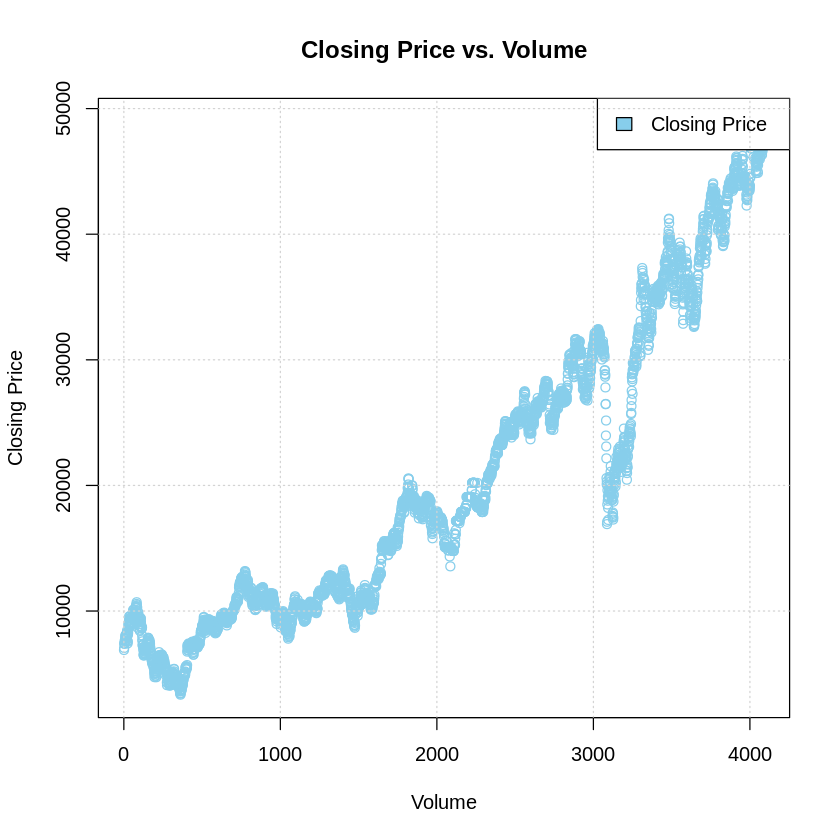

In [ ]:
plot(clean_data$Close, names.arg = clean_data$Volume, xlab = "Volume", ylab = "Closing Price",
        main = "Closing Price vs. Volume", col = "skyblue", border = "black",
        space = 0.5)

# Adding a legend
legend("topright", legend = "Closing Price", fill = "skyblue")

# Adding gridlines for clarity (optional)
grid()

**D2. Opening Price vs Closing Price**

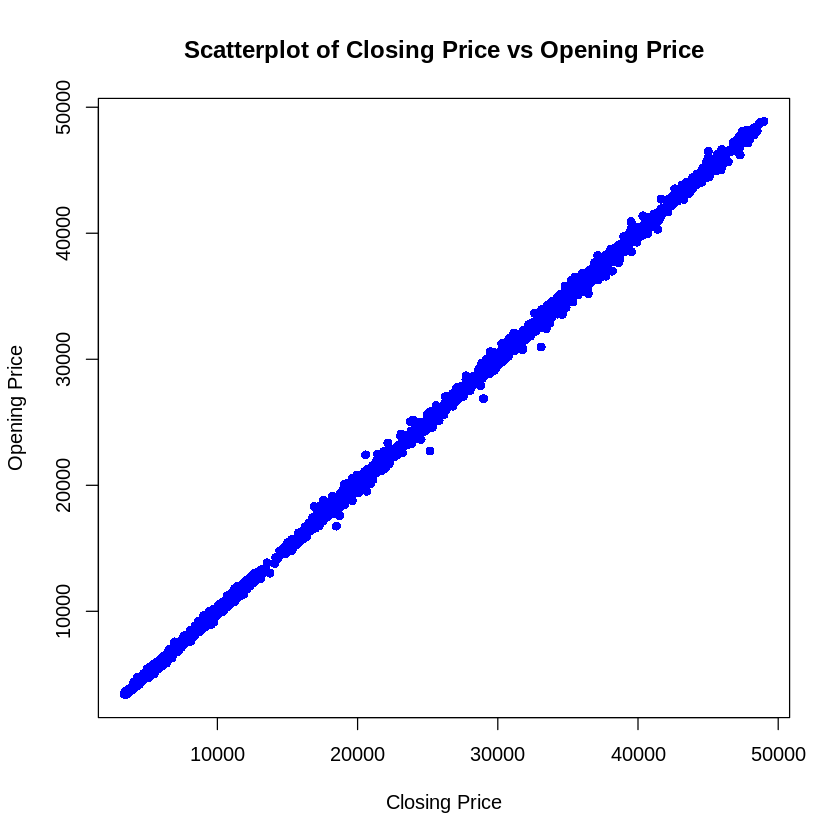

In [ ]:
# Customized scatterplot
plot(clean_data$Close, clean_data$Open,
     col = "blue",  # Change point color
     pch = 16,      # Use solid circles for points
     xlab = "Closing Price",
     ylab = "Opening Price",
     main = "Scatterplot of Closing Price vs Opening Price")



**D3. Date vs Closing, Opening Price**

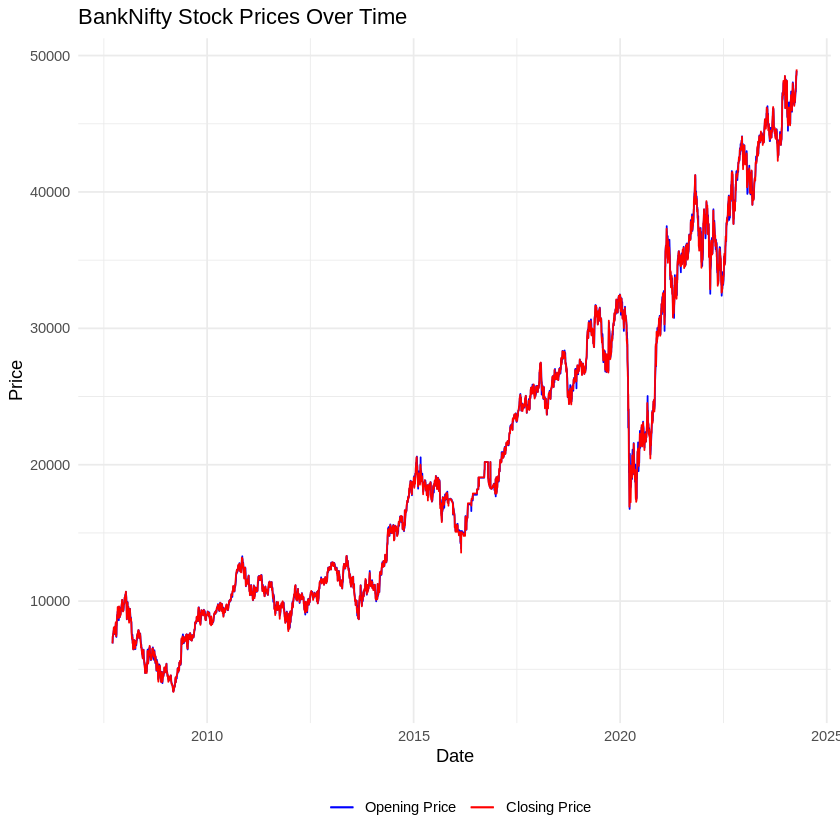

In [ ]:
# Convert 'Date' to Date format
clean_data$Date <- as.Date(clean_data$Date, format="%Y-%m-%d")

# Plotting the prices
ggplot(clean_data, aes(x = Date)) +
  geom_line(aes(y = Open, color = "Opening Price")) +
  geom_line(aes(y = Close, color = "Closing Price")) +
  labs(title = "BankNifty Stock Prices Over Time", x = "Date", y = "Price") +
  scale_color_manual("",
                     breaks = c("Opening Price", "Closing Price"),
                     values = c("blue", "red")) +
  theme_minimal() +
  theme(legend.position = "bottom")


**D4. Date vs High, Low Price**

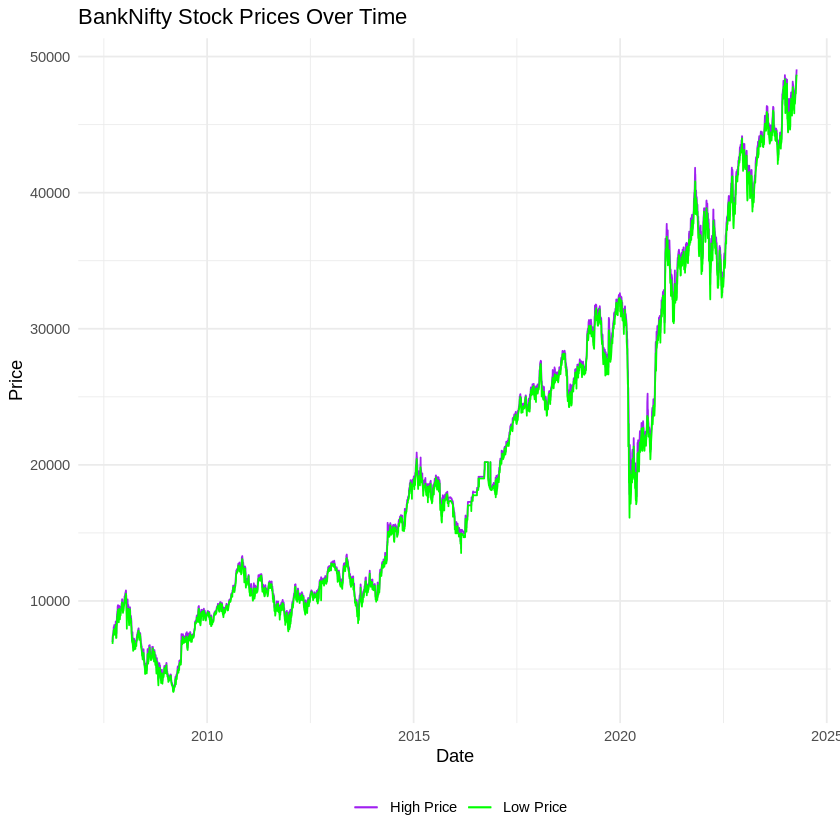

In [ ]:
# Convert 'Date' to Date format
clean_data$Date <- as.Date(clean_data$Date, format="%Y-%m-%d")

# Plotting the prices
ggplot(clean_data, aes(x = Date)) +
  geom_line(aes(y = High, color = "High Price")) +
  geom_line(aes(y = Low, color = "Low Price")) +
  labs(title = "BankNifty Stock Prices Over Time", x = "Date", y = "Price") +
  scale_color_manual("",
                     breaks = c("High Price", "Low Price"),
                     values = c("purple", "green")) +
  theme_minimal()+
  theme(legend.position = "bottom")

We can observe the overall trend of the stock prices (opening, closing, high, and low) over time.

 Any sharp spikes or drops may indicate significant market events or reactions to news.


**D5. Avg-Closing-Opening Difference Per Month Over time**

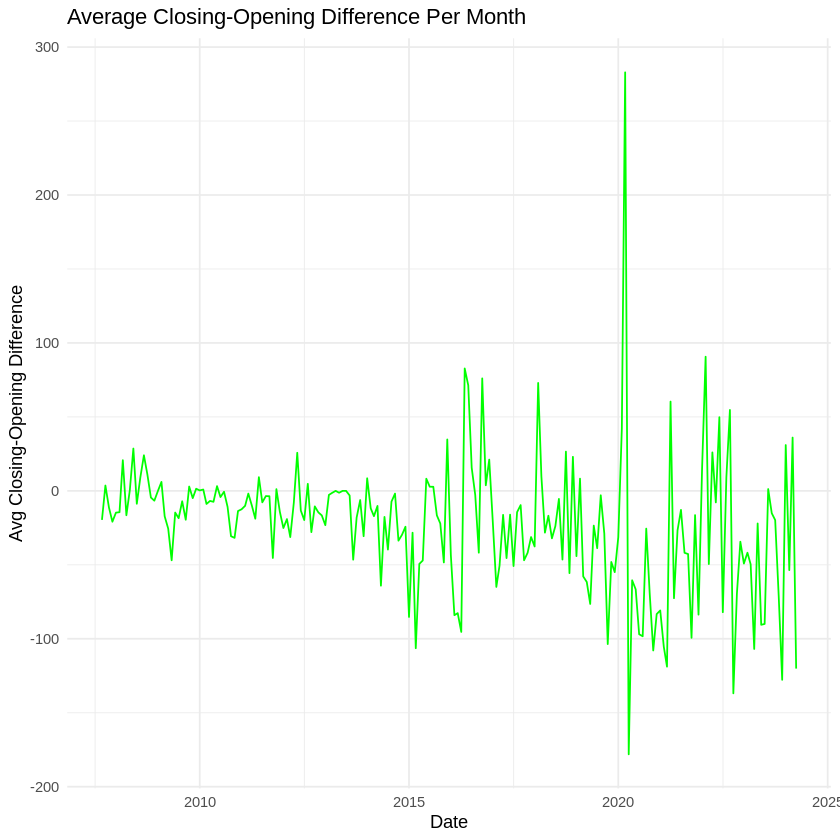

In [ ]:
clean_data$Date <- as.Date(clean_data$Date)

# Aggregate the data by month and calculate the average closing_opening_difference
monthly_data <- clean_data %>%
  mutate(Month = format(Date, "%Y-%m")) %>% # Extract year-month
  group_by(Month) %>%
  summarize(avg_closing_opening_difference = mean(closing_opening_difference, na.rm = TRUE))

# Convert Month back to Date type for proper plotting
# Convert Month to Date type for proper plotting
monthly_data$Month <- as.Date(paste(monthly_data$Month, "-01", sep=""))

# Plot the average closing_opening_difference per month
ggplot(monthly_data, aes(x = Month, y = avg_closing_opening_difference)) +
  geom_line(color = "green") +
  labs(title = "Average Closing-Opening Difference Per Month",
       x = "Date",
       y = "Avg Closing-Opening Difference") +
  theme_minimal()


**D6 .**Average Today Point Difference Per Month Over Time

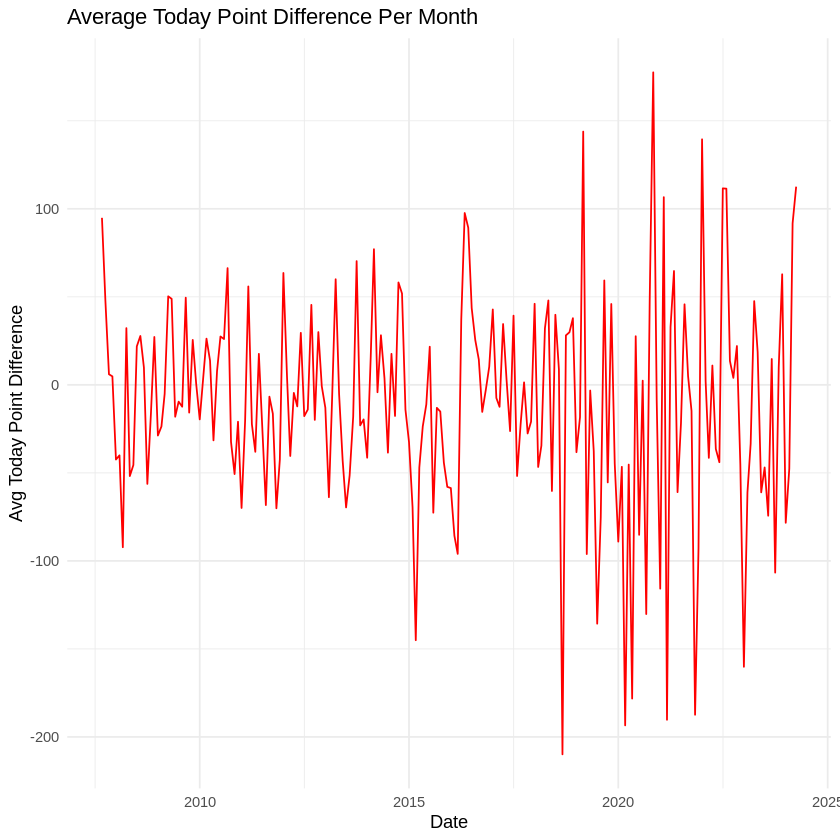

In [ ]:
clean_data$Date <- as.Date(clean_data$Date)

# Aggregate the data by month and calculate the average today_point_difference
monthly_data <- clean_data %>%
  mutate(Month = format(Date, "%Y-%m")) %>% # Extract year-month
  group_by(Month) %>%
  summarize(avg_today_point_difference = mean(Today_point_difference, na.rm = TRUE))

# Convert Month back to Date type for proper plotting
monthly_data$Month <- as.Date(paste(monthly_data$Month, "-01", sep=""))

# Plot the average today_point_difference per month with date on x-axis
ggplot(monthly_data, aes(x = Month, y = avg_today_point_difference)) +
  geom_line(color = "red") +
  labs(title = "Average Today Point Difference Per Month",
       x = "Date",
       y = "Avg Today Point Difference") +
  theme_minimal()

**D7. Average-Today-Point Difference and Avg-Closing-Opening Difference Per Year**

In [ ]:
# Import the tidyr package
install.packages("tidyr")
library(tidyr)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



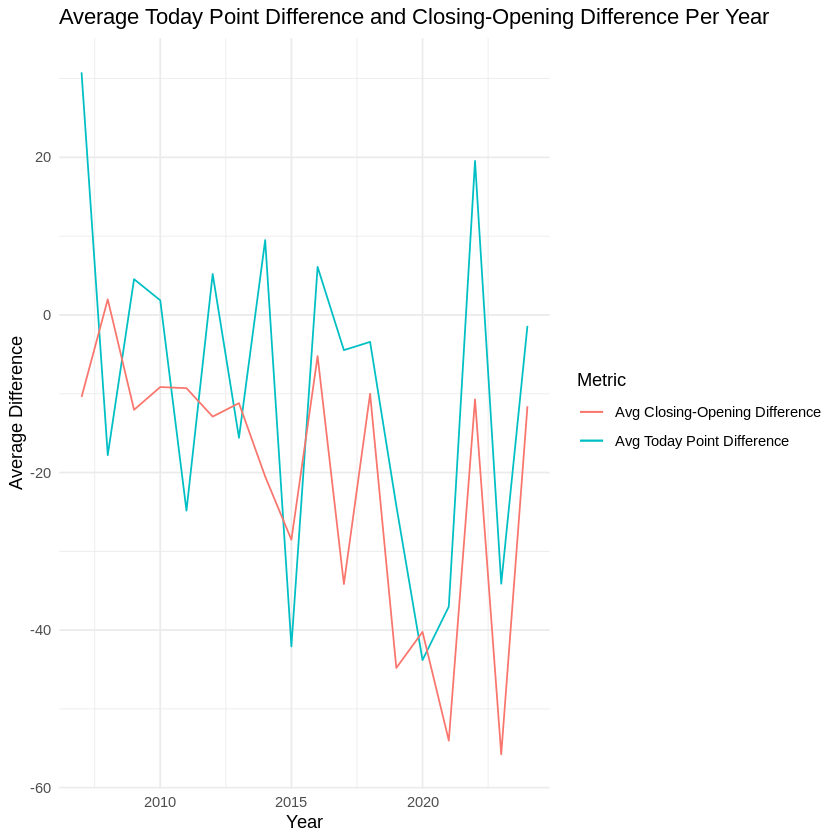

In [ ]:

# Aggregate the data by year and calculate the average Today_point_difference and closing_opening_difference
yearly_data <- clean_data %>%
  mutate(Year = format(Date, "%Y")) %>% # Extract year
  group_by(Year) %>%
  summarize(
    avg_Today_point_difference = mean(Today_point_difference, na.rm = TRUE),
    avg_closing_opening_difference = mean(closing_opening_difference, na.rm = TRUE)
  )

# Convert Year back to Date type for proper plotting
yearly_data$Year <- as.Date(paste(yearly_data$Year, "-01-01", sep=""))

# Plot the average Today_point_difference and avg_closing_opening_difference per year
ggplot(yearly_data) +
  geom_line(aes(x = Year, y = avg_Today_point_difference, color = "Avg Today Point Difference")) +
  geom_line(aes(x = Year, y = avg_closing_opening_difference, color = "Avg Closing-Opening Difference")) +
  labs(title = "Average Today Point Difference and Avg-Closing-Opening Difference Per Year",
       x = "Year",
       y = "Average Difference",
       color = "Metric") +
  theme_minimal()


**Candlestick graph**

In [ ]:
# Load necessary libraries
library(quantmod)
install.packages("xts")
library(xts)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



**D8. Year 2020 (Month wise)**

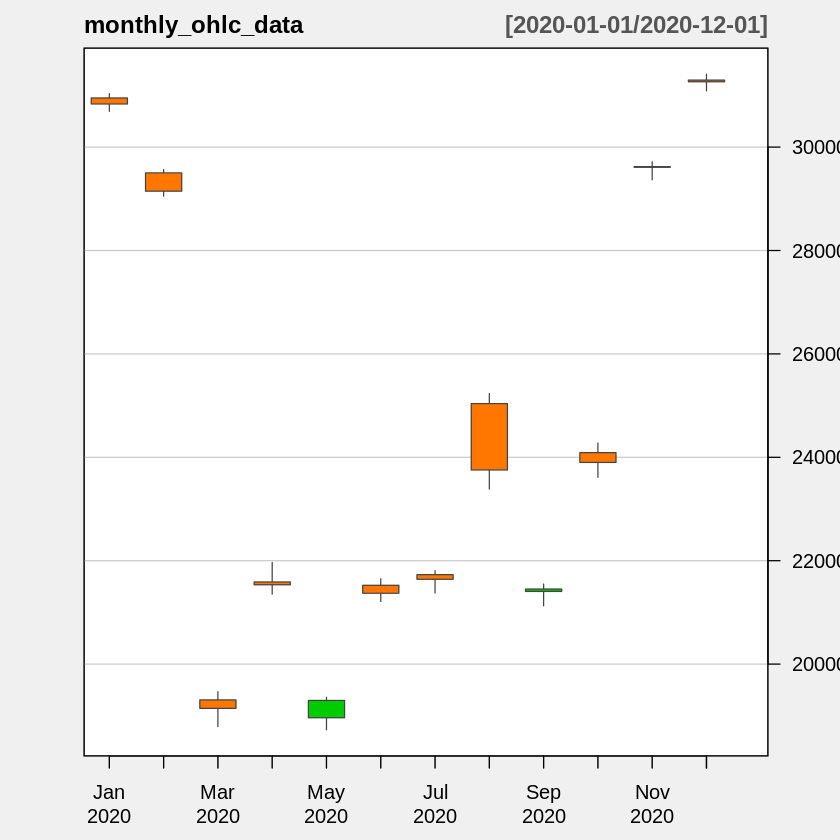

In [ ]:
# Load the Bank Nifty dataset
clean_data <- read.csv('/content/clean_data.csv')
clean_data$Date <- as.Date(clean_data$Date)

# Filter data for the year 2020
clean_data_2020 <- clean_data[format(clean_data$Date, "%Y") == "2020", ]

# Ensure columns are named correctly for quantmod
ohlc_data <- xts(
  x = clean_data_2020[, c("Open", "High", "Low", "Close")],
  order.by = clean_data_2020$Date
)

# Rename columns to standard OHLC names (Open, High, Low, Close)
colnames(ohlc_data) <- c("Open", "High", "Low", "Close")


# Aggregate data by month using the aggregate function

monthly_ohlc_data <- aggregate(ohlc_data, by = as.Date(format(index(ohlc_data), "%Y-%m-01")), FUN = last)

# Plot the candlestick chart
candleChart(monthly_ohlc_data, theme = "white", TA = NULL)

**D9. Year 2020(Feb - Apr)**

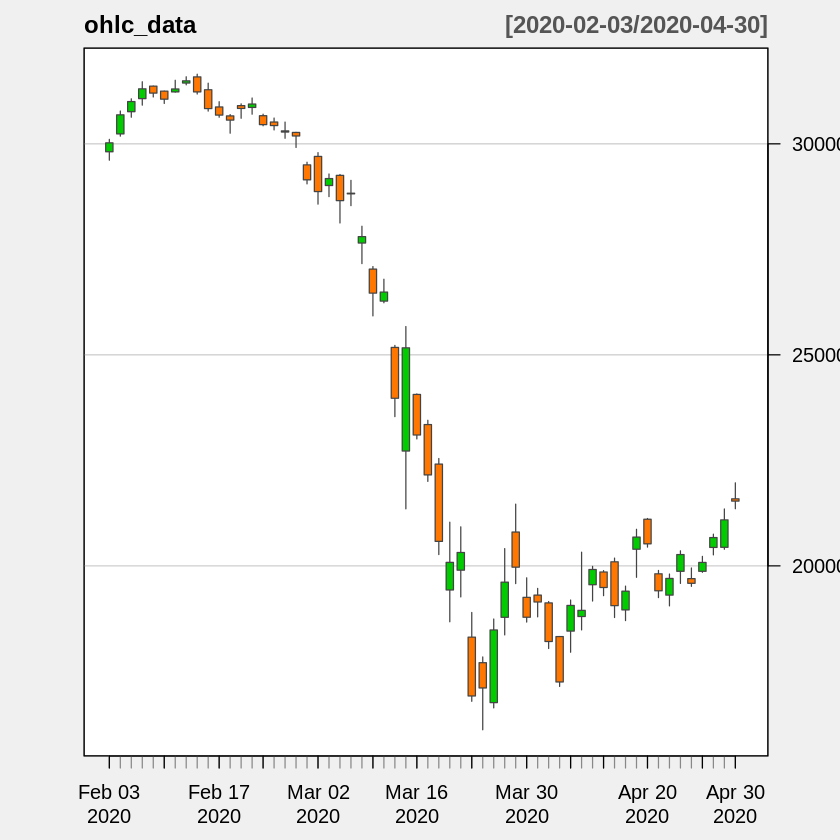

In [ ]:
# Load necessary libraries
#library(quantmod)

# Load the Bank Nifty dataset
clean_data <- read.csv('/content/clean_data.csv')
clean_data$Date <- as.Date(clean_data$Date)

# Filter data for the year 2020 and months April to June
clean_data_2020 <- clean_data[format(clean_data$Date, "%Y") == "2020" &
                              format(clean_data$Date, "%m") %in% c("02", "03", "04"), ]

# Ensure columns are named correctly for quantmod
ohlc_data <- xts(
  x = clean_data_2020[, c("Open", "High", "Low", "Close")],
  order.by = clean_data_2020$Date
)

# Rename columns to standard OHLC names (Open, High, Low, Close)
colnames(ohlc_data) <- c("Open", "High", "Low", "Close")

# Plot the candlestick chart
candleChart(ohlc_data, theme = "white", TA = NULL)


**D10. Year 2020 (Apr - June)**

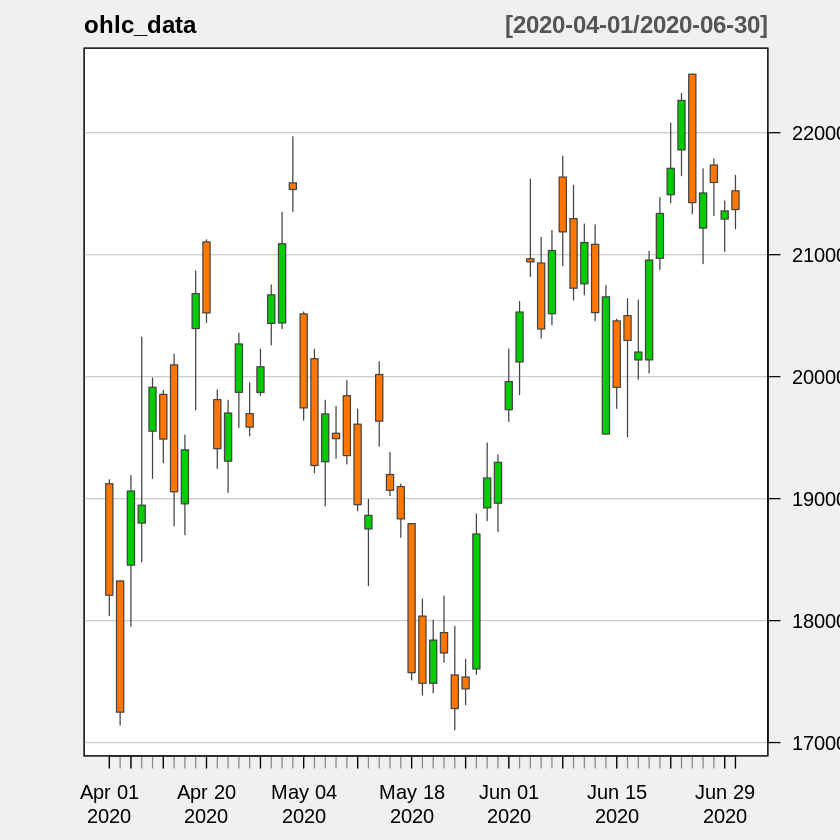

In [ ]:
# Load necessary libraries
#library(quantmod)

# Load the Bank Nifty dataset
#clean_data <- read.csv('/content/clean_data.csv')
clean_data$Date <- as.Date(clean_data$Date)

# Filter data for the year 2020 and months April to June
clean_data_2020 <- clean_data[format(clean_data$Date, "%Y") == "2020" &
                              format(clean_data$Date, "%m") %in% c("04", "05", "06"), ]

# Ensure columns are named correctly for quantmod
ohlc_data <- xts(
  x = clean_data_2020[, c("Open", "High", "Low", "Close")],
  order.by = clean_data_2020$Date
)

# Rename columns to standard OHLC names (Open, High, Low, Close)
colnames(ohlc_data) <- c("Open", "High", "Low", "Close")

# Plot the candlestick chart
candleChart(ohlc_data, theme = "white", TA = NULL)


**D11. Year 2021(Feb - Apr)**

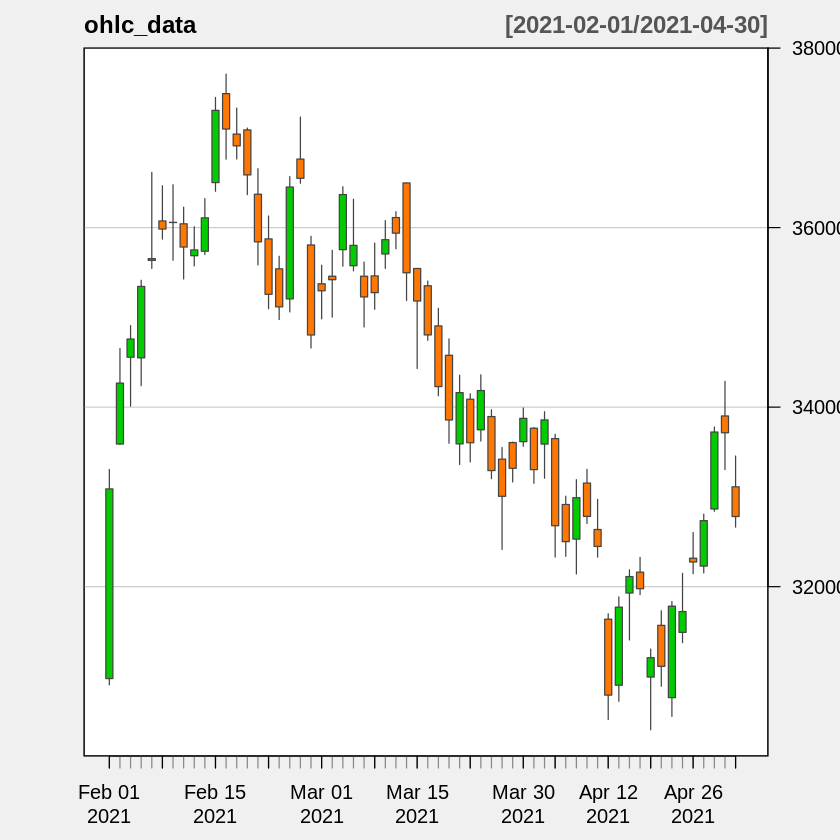

In [ ]:
# Load necessary libraries
#library(quantmod)

# Load the Bank Nifty dataset
clean_data <- read.csv('/content/clean_data.csv')
clean_data$Date <- as.Date(clean_data$Date)

# Filter data for the year 2020 and months April to June
clean_data_2020 <- clean_data[format(clean_data$Date, "%Y") == "2021" &
                              format(clean_data$Date, "%m") %in% c("02", "03", "04"), ]

# Ensure columns are named correctly for quantmod
ohlc_data <- xts(
  x = clean_data_2020[, c("Open", "High", "Low", "Close")],
  order.by = clean_data_2020$Date
)

# Rename columns to standard OHLC names (Open, High, Low, Close)
colnames(ohlc_data) <- c("Open", "High", "Low", "Close")

# Plot the candlestick chart
candleChart(ohlc_data, theme = "white", TA = NULL)


**D12. Year 2022(Feb - Apr)**

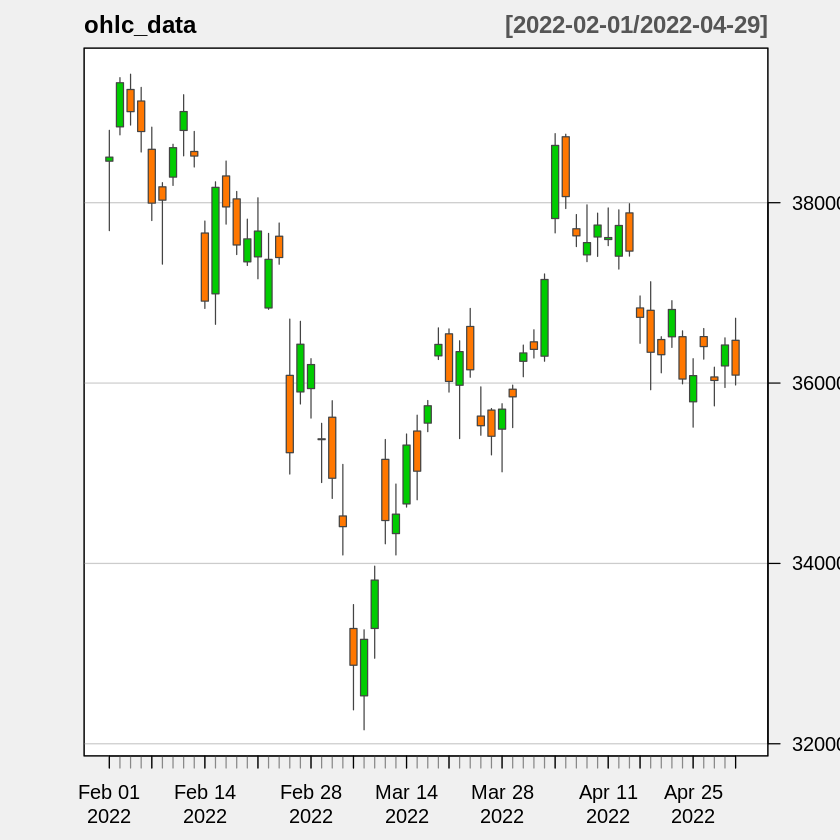

In [ ]:
# Load necessary libraries
#library(quantmod)

# Load the Bank Nifty dataset
clean_data <- read.csv('/content/clean_data.csv')
clean_data$Date <- as.Date(clean_data$Date)

# Filter data for the year 2020 and months April to June
clean_data_2020 <- clean_data[format(clean_data$Date, "%Y") == "2022" &
                              format(clean_data$Date, "%m") %in% c("02", "03", "04"), ]

# Ensure columns are named correctly for quantmod
ohlc_data <- xts(
  x = clean_data_2020[, c("Open", "High", "Low", "Close")],
  order.by = clean_data_2020$Date
)

# Rename columns to standard OHLC names (Open, High, Low, Close)
colnames(ohlc_data) <- c("Open", "High", "Low", "Close")

# Plot the candlestick chart
candleChart(ohlc_data, theme = "white", TA = NULL)


**D13. Year 2023(Feb - Apr)**

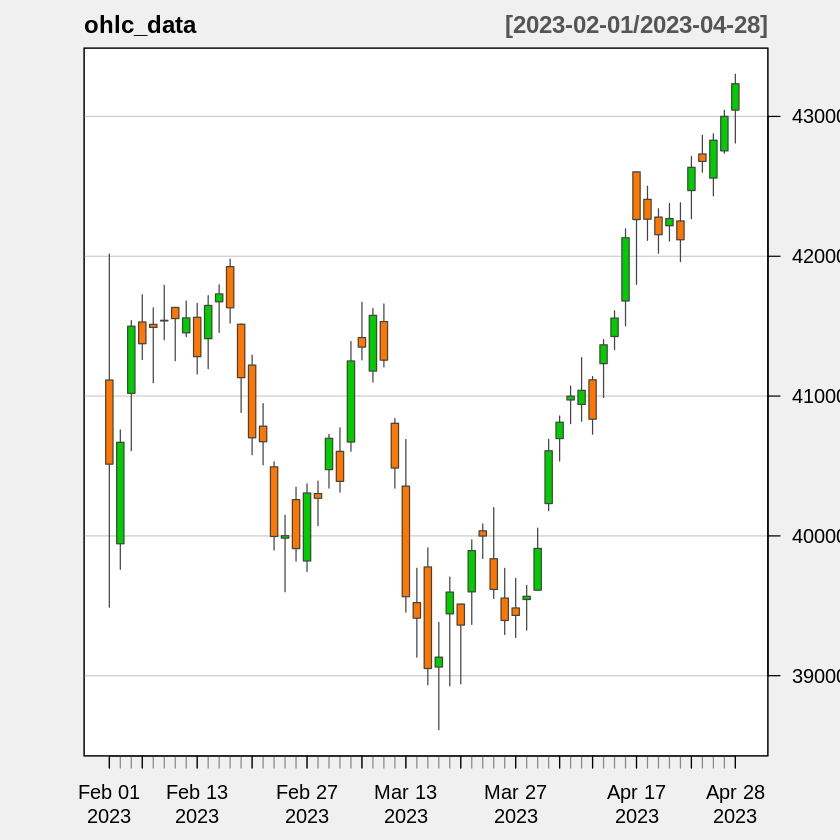

In [ ]:
# Load necessary libraries
#library(quantmod)

# Load the Bank Nifty dataset
#clean_data <- read.csv('/content/clean_data.csv')
clean_data$Date <- as.Date(clean_data$Date)

# Filter data for the year 2023 and months April to June
clean_data_2023 <- clean_data[format(clean_data$Date, "%Y") == "2023" &
                              format(clean_data$Date, "%m") %in% c("02", "03", "04"), ]

# Ensure columns are named correctly for quantmod
ohlc_data <- xts(
  x = clean_data_2023[, c("Open", "High", "Low", "Close")],
  order.by = clean_data_2023$Date
)

# Rename columns to standard OHLC names (Open, High, Low, Close)
colnames(ohlc_data) <- c("Open", "High", "Low", "Close")

# Plot the candlestick chart
candleChart(ohlc_data, theme = "white", TA = NULL)


# **Modeling**

**M1. ARIMA**


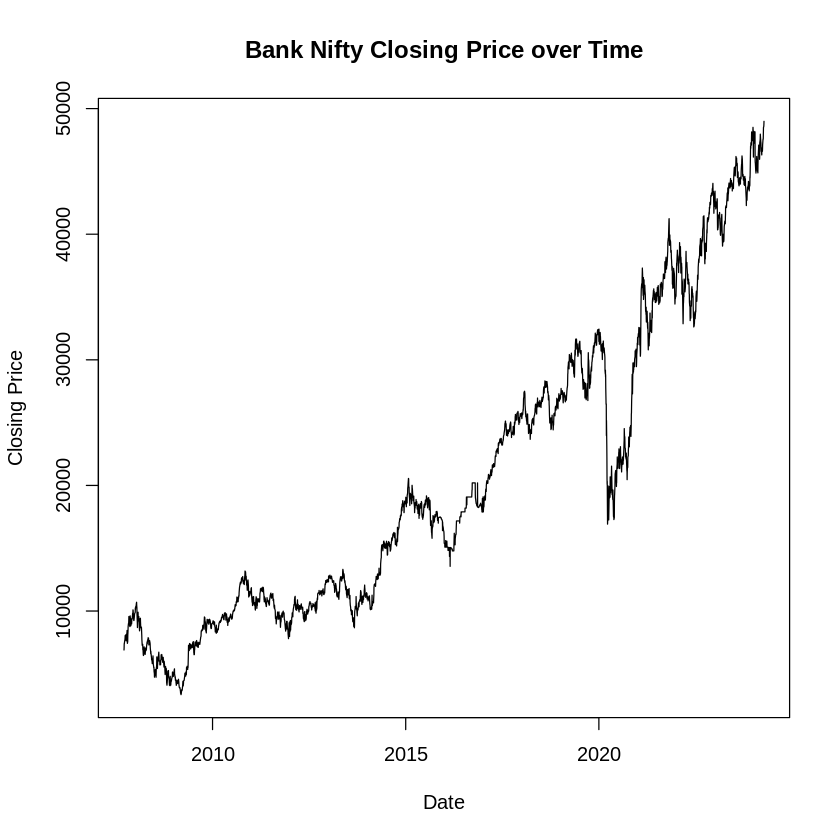

In [ ]:
# Load the Bank Nifty dataset
# Assuming you have a CSV file named 'banknifty_data.csv' with columns: 'Date', 'Close'
data <- read.csv('/content/clean_data.csv')
data$Date <- as.Date(data$Date)

# Plot the time series data
plot(data$Date, data$Close, type='l', xlab='Date', ylab='Closing Price',
     main='Bank Nifty Closing Price over Time')

# Check for stationarity using the Augmented Dickey-Fuller test

# If the p-value is greater than 0.05, the series is non-stationary and needs differencing

# Plot ACF and PACF to determine ARIMA parameters


In [ ]:
adf_test_result <- adf.test(data$Close)
print(adf_test_result)


	Augmented Dickey-Fuller Test

data:  data$Close
Dickey-Fuller = -2.7608, Lag order = 15, p-value = 0.2562
alternative hypothesis: stationary



In [ ]:
# If the p-value is greater than 0.05, the series is non-stationary and needs differencing
if (adf_test_result$p.value > 0.05) {
  data_diff <- diff(data$Close)
  adf_test_diff_result <- adf.test(data_diff)
  print(adf_test_diff_result)
} else {
  data_diff <- data$Close
}

Warning message in adf.test(data_diff):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  data_diff
Dickey-Fuller = -15.495, Lag order = 15, p-value = 0.01
alternative hypothesis: stationary



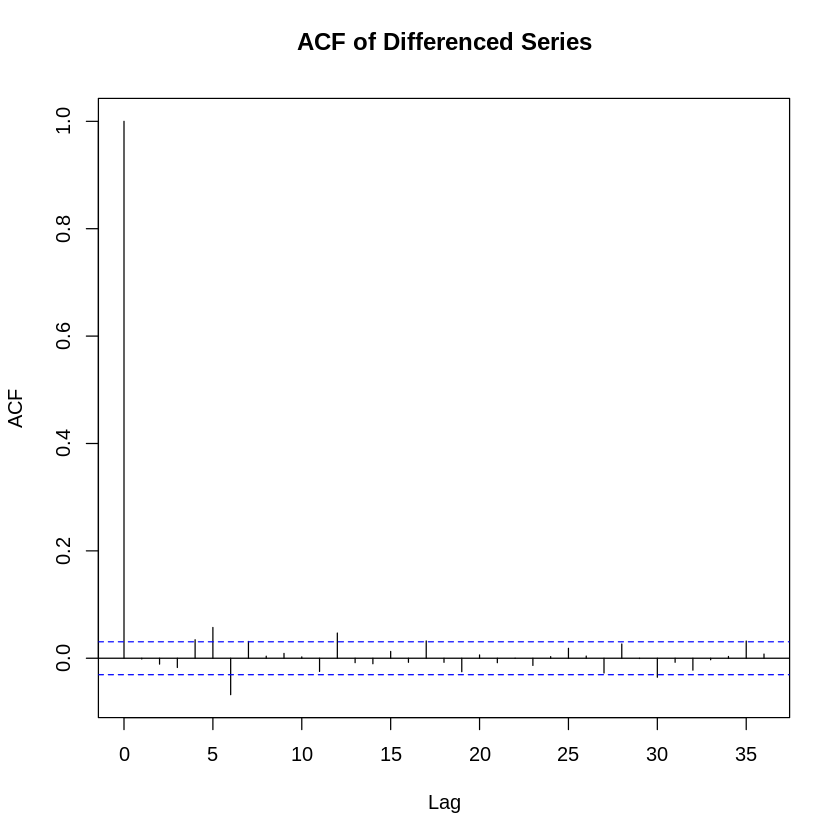

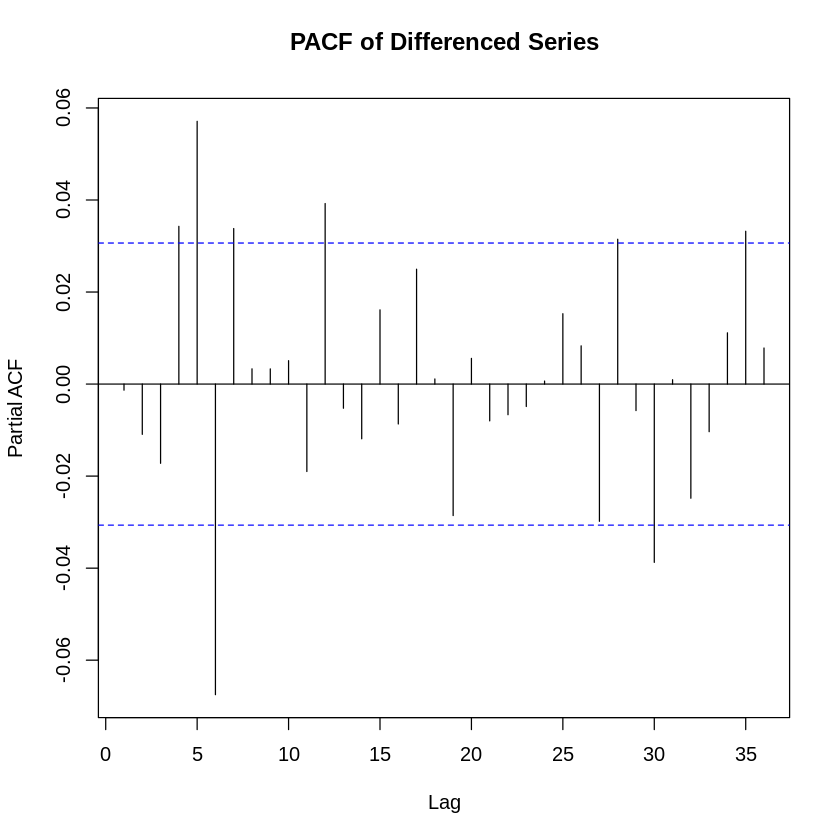

In [ ]:
# Plot ACF and PACF to determine ARIMA parameters
acf(data_diff, main='ACF of Differenced Series')
pacf(data_diff, main='PACF of Differenced Series')

In [ ]:
model <- auto.arima(data$Close, seasonal = FALSE)

In [ ]:
# Fit ARIMA model
# Assuming we determine ARIMA(1,1,1) based on the ACF and PACF plots

# Print model summary
print(summary(model))

Series: data$Close 
ARIMA(0,1,0) with drift 

Coefficients:
        drift
      10.2933
s.e.   5.1242

sigma^2 = 107394:  log likelihood = -29485.56
AIC=58975.13   AICc=58975.13   BIC=58987.76

Training set error measures:
                      ME     RMSE      MAE         MPE     MAPE    MASE
Training set 0.001683815 327.6305 211.9983 -0.04297945 1.250734 1.00044
                    ACF1
Training set -0.00131814


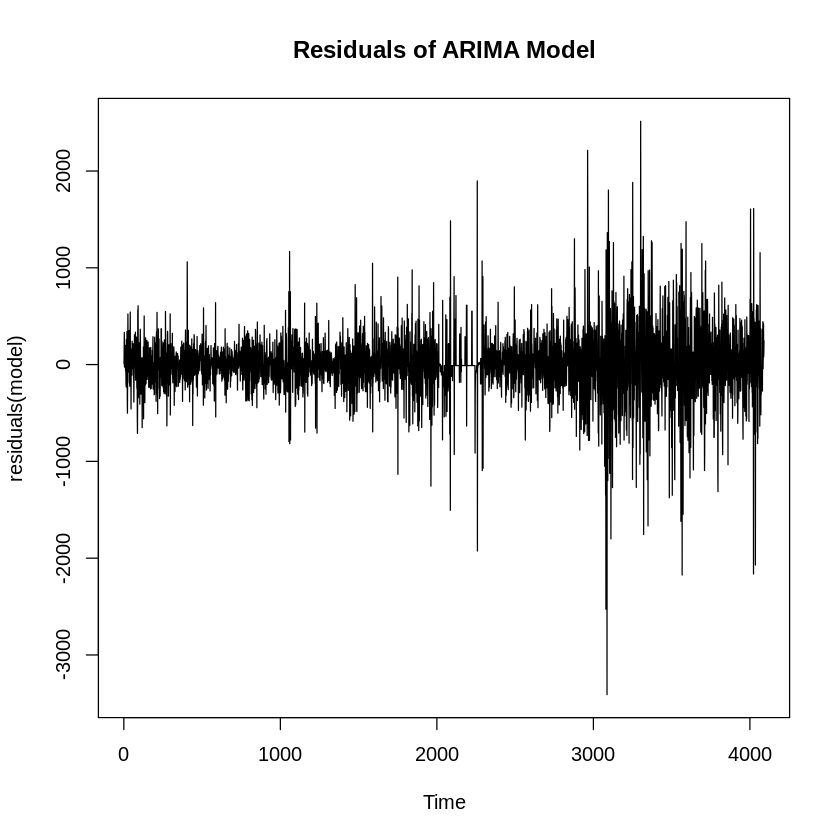

In [ ]:
plot(residuals(model),main='Residuals of ARIMA Model')

In [ ]:
forecast_result <- forecast::forecast(model, h=5)
print(forecast_result)

     Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
4091       48996.89 48576.92 49416.87 48354.59 49639.20
4092       49007.19 48413.25 49601.13 48098.84 49915.54
4093       49017.48 48290.06 49744.90 47904.98 50129.98
4094       49027.77 48187.82 49867.73 47743.17 50312.38
4095       49038.07 48098.97 49977.17 47601.84 50474.30


In [ ]:
# Print forecasted values
cat("Forecasted closing prices for the next 5 days:\n")
print(forecast_result$mean)

Forecasted closing prices for the next 5 days:
Time Series:
Start = 4091 
End = 4095 
Frequency = 1 
[1] 48996.89 49007.19 49017.48 49027.77 49038.07


**Model Evaluation**

In [ ]:
actual_values <- c(47773, 47484, 47069,47574,47924)  # Replace with actual values

# Predicted values
predicted_values <- as.numeric(forecast_result$mean)

# Calculate evaluation metrics
mae <- mean(abs(actual_values - predicted_values))
mse <- mean((actual_values - predicted_values)^2)
rmse <- sqrt(mse)
mape <- mean(abs((actual_values - predicted_values) / actual_values)) * 100

# Print evaluation metrics
cat("Mean Absolute Error (MAE): ", mae, "\n")
cat("Mean Squared Error (MSE): ", mse, "\n")
cat("Root Mean Squared Error (RMSE): ", rmse, "\n")
cat("Mean Absolute Percentage Error (MAPE): ", mape, "\n")

Mean Absolute Error (MAE):  1452.682 
Mean Squared Error (MSE):  2193842 
Root Mean Squared Error (RMSE):  1481.162 
Mean Absolute Percentage Error (MAPE):  3.057958 


**M2. LSTM**

In [ ]:
# Load the Bank Nifty dataset
# Assuming you have a CSV file named 'banknifty_data.csv' with columns: 'Date', 'Close'
data <- read.csv('/content/clean_data.csv')
data$Date <- as.Date(data$Date)

# Data preprocessing
# Normalize the data
min_value <- min(data$Close)
max_value <- max(data$Close)
scaled_data <- (data$Close - min_value) / (max_value - min_value)

# Define a function to create sequences of data for LSTM
create_sequences <- function(data, time_steps) {
  sequences <- matrix(NA, nrow = length(data) - time_steps + 1, ncol = time_steps)
  for (i in 1:(length(data) - time_steps + 1)) {
    sequences[i, ] <- data[i:(i + time_steps - 1)]  # Adjust the indices to include the current time step
  }
  return(sequences)
}

# Define time steps
time_steps <- 5

# Create sequences of data for LSTM
sequences <- create_sequences(scaled_data, time_steps)

# Split data into training and testing sets
train_size <- floor(0.8 * nrow(sequences))
train_data <- sequences[1:train_size, ]
test_data <- sequences[(train_size + 1):nrow(sequences), ]

# Prepare input and output variables
x_train <- train_data[, -time_steps, drop = FALSE]
y_train <- train_data[, time_steps, drop = FALSE]
x_test <- test_data[, -time_steps, drop = FALSE]
y_test <- test_data[, time_steps, drop = FALSE]

# Reshape input data for LSTM
dim(x_train) <- c(dim(x_train), 1)
dim(x_test) <- c(dim(x_test), 1)

# Build the LSTM model
model <- keras_model_sequential()
model %>%
  layer_lstm(units = 50, input_shape = c(time_steps - 1, 1)) %>%  # Change the input shape to match the training data
  layer_dense(units = 1)
# Compile the model
model %>% compile(
  optimizer = 'adam',
  loss = 'mean_squared_error'
)


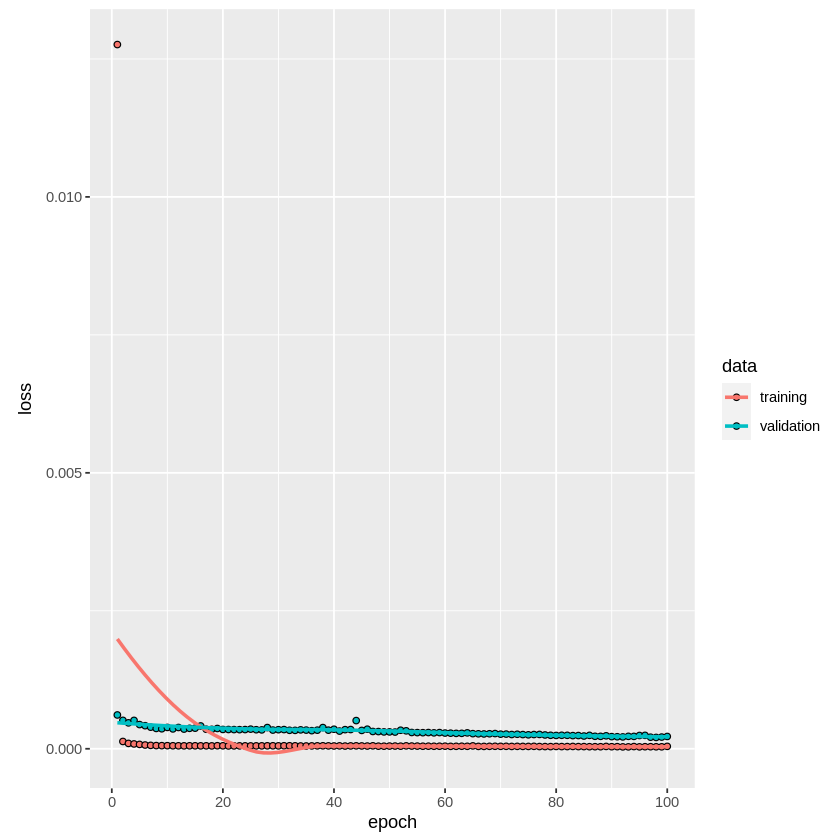

In [ ]:
# Train the model
history <- model %>% fit(
  x_train, y_train,
  epochs = 100,
  batch_size = 32,
  validation_split = 0.1
)

# Plot training history
plot(history)

In [ ]:
#Evaluate the model

evaluation <- model %>% evaluate(x_test, y_test)
print(evaluation)

        loss 
0.0001603449 


In [ ]:
# Make predictions
predictions <- model %>% predict(x_test)
print(predictions)

            [,1]
  [1,] 0.6072074
  [2,] 0.6064382
  [3,] 0.5905032
  [4,] 0.5847363
  [5,] 0.5853518
  [6,] 0.5926616
  [7,] 0.6026038
  [8,] 0.6126429
  [9,] 0.6168497
 [10,] 0.6178796
 [11,] 0.6245140
 [12,] 0.6203828
 [13,] 0.6246395
 [14,] 0.6275430
 [15,] 0.6308454
 [16,] 0.6340469
 [17,] 0.6342490
 [18,] 0.6384631
 [19,] 0.6433264
 [20,] 0.6448979
 [21,] 0.6420935
 [22,] 0.6350915
 [23,] 0.6393439
 [24,] 0.6430899
 [25,] 0.6406264
 [26,] 0.6266462
 [27,] 0.6200542
 [28,] 0.6058306
 [29,] 0.6004143
 [30,] 0.6009465
 [31,] 0.6329517
 [32,] 0.6635887
 [33,] 0.6838358
 [34,] 0.6994928
 [35,] 0.7091776
 [36,] 0.7171289
 [37,] 0.7212892
 [38,] 0.7193669
 [39,] 0.7178383
 [40,] 0.7215293
 [41,] 0.7385358
 [42,] 0.7437826
 [43,] 0.7435859
 [44,] 0.7388194
 [45,] 0.7268046
 [46,] 0.7140551
 [47,] 0.7066506
 [48,] 0.7205975
 [49,] 0.7288034
 [50,] 0.7106104
 [51,] 0.7079901
 [52,] 0.7079566
 [53,] 0.7205355
 [54,] 0.7196617
 [55,] 0.7116566
 [56,] 0.7082061
 [57,] 0.7139795
 [58,] 0.71800

In [ ]:
# Denormalize predictions
denormalized_predictions <- predictions * (max_value - min_value) + min_value
print(denormalized_predictions)

           [,1]
  [1,] 31056.84
  [2,] 31021.72
  [3,] 30294.34
  [4,] 30031.10
  [5,] 30059.20
  [6,] 30392.87
  [7,] 30846.70
  [8,] 31304.95
  [9,] 31496.98
 [10,] 31543.99
 [11,] 31846.83
 [12,] 31658.25
 [13,] 31852.56
 [14,] 31985.09
 [15,] 32135.84
 [16,] 32281.98
 [17,] 32291.20
 [18,] 32483.56
 [19,] 32705.56
 [20,] 32777.29
 [21,] 32649.28
 [22,] 32329.66
 [23,] 32523.77
 [24,] 32694.76
 [25,] 32582.31
 [26,] 31944.16
 [27,] 31643.25
 [28,] 30993.99
 [29,] 30746.75
 [30,] 30771.05
 [31,] 32231.98
 [32,] 33630.47
 [33,] 34554.69
 [34,] 35269.38
 [35,] 35711.46
 [36,] 36074.41
 [37,] 36264.32
 [38,] 36176.57
 [39,] 36106.79
 [40,] 36275.28
 [41,] 37051.57
 [42,] 37291.07
 [43,] 37282.09
 [44,] 37064.51
 [45,] 36516.08
 [46,] 35934.10
 [47,] 35596.11
 [48,] 36232.74
 [49,] 36607.32
 [50,] 35776.87
 [51,] 35657.25
 [52,] 35655.73
 [53,] 36229.91
 [54,] 36190.02
 [55,] 35824.62
 [56,] 35667.11
 [57,] 35930.65
 [58,] 36114.52
 [59,] 35950.79
 [60,] 35682.30
 [61,] 35330.06
 [62,] 3

In [ ]:
length(denormalized_predictions)

[1] 818

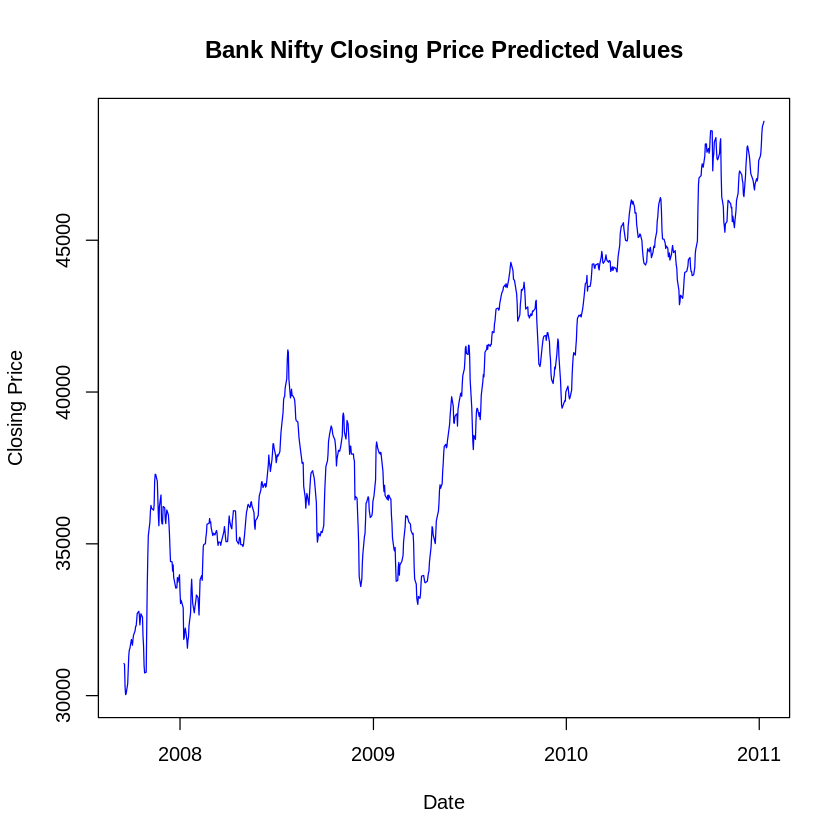

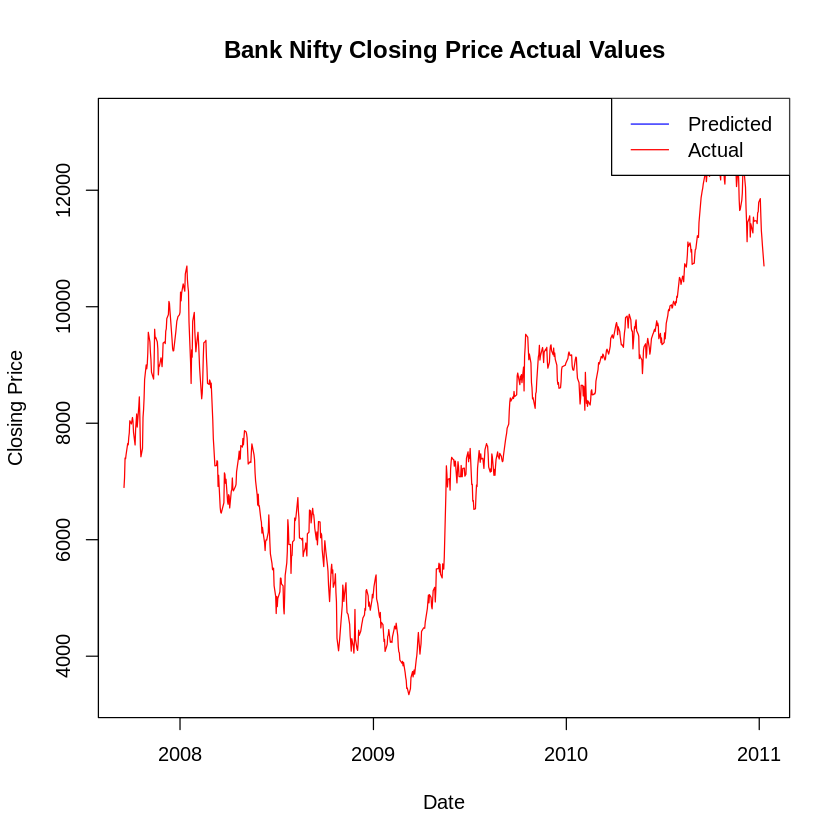

In [ ]:
plot(clean_data$Date[1:818], denormalized_predictions, type = 'l', col = 'blue',
     xlab = 'Date', ylab = 'Closing Price', main = 'Bank Nifty Closing Price Predicted Values')
plot(clean_data$Date[1:818],clean_data$Close[1:818] , col = 'red', type='l',
     xlab = 'Date', ylab = 'Closing Price', main = 'Bank Nifty Closing Price Actual Values')
legend('topright', legend = c('Predicted', 'Actual'), col = c('blue', 'red'), lty = 1)

In [ ]:
# Get the last sequence from the test data
last_sequence <- x_test[nrow(x_test), , , drop = FALSE]

# Initialize an empty vector to store the predictions
future_predictions <- numeric(5)

# Iteratively predict the next 5 days
for (i in 1:5) {
  # Predict the next value
  next_value <- model %>% predict(last_sequence)

  # Store the predicted value
  future_predictions[i] <- next_value

  # Update the sequence: remove the first value and append the predicted value
  last_sequence <- array(c(last_sequence[1, 2:(time_steps - 1), 1], next_value), dim = c(1, time_steps - 1, 1))
}

# Denormalize the predicted values
denormalized_future_predictions <- future_predictions * (max_value - min_value) + min_value

# Print the forecasted values
cat("Forecasted closing prices for the next 5 days:\n", denormalized_future_predictions, "\n")

Forecasted closing prices for the next 5 days:
 48915.79 49088.34 49257.15 49426.4 49594.81 


In [ ]:
actual_values <- c(47773, 47484, 47069,47574,47924)  # Replace with actual values

# Predicted values
predicted_values <- as.numeric(denormalized_future_predictions)

# Calculate evaluation metrics
mae <- mean(abs(actual_values - predicted_values))
mse <- mean((actual_values - predicted_values)^2)
rmse <- sqrt(mse)
mape <- mean(abs((actual_values - predicted_values) / actual_values)) * 100

# Print evaluation metrics
cat("Mean Absolute Error (MAE): ", mae, "\n")
cat("Mean Squared Error (MSE): ", mse, "\n")
cat("Root Mean Squared Error (RMSE): ", rmse, "\n")
cat("Mean Absolute Percentage Error (MAPE): ", mape, "\n")

Mean Absolute Error (MAE):  1691.7 
Mean Squared Error (MSE):  2978181 
Root Mean Squared Error (RMSE):  1725.741 
Mean Absolute Percentage Error (MAPE):  3.559951 
